In [1]:
include("speciale_tools.jl")
import JLD
import PyPlot

In [2]:
data_folder = "/Users/simon/Documents/DTU fag/Speciale/ribe_new"
VV_files,VH_files,coherence_VV_files,coherence_VH_files = _sort_prossed_files(data_folder);

In [62]:
VV = _load_jld(VV_files[[1,4]],data_folder);
VH = _load_jld(VH_files[[1,4]],data_folder);

## VV

In [63]:
co = VV[1][end:-1:1,:]
pre = VV[2][end:-1:1,:];

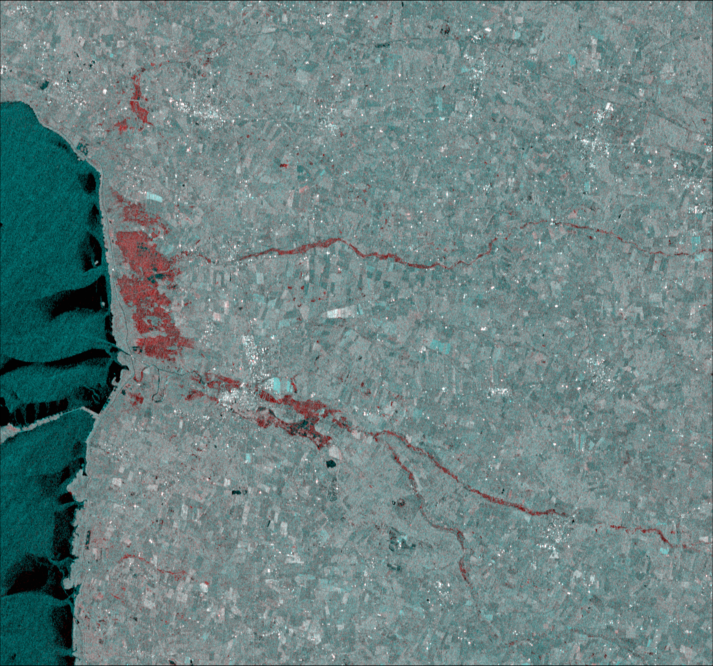

In [64]:
imgVV = pretty_img([co,pre],min_vv,max_vv)

In [65]:
flood_band = 10 .*log10.(co);
ref_band = 10 .*log10.(pre);
change_band = flood_band .- ref_band;

In [66]:
# Find the tiles to fit bimodal
bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;


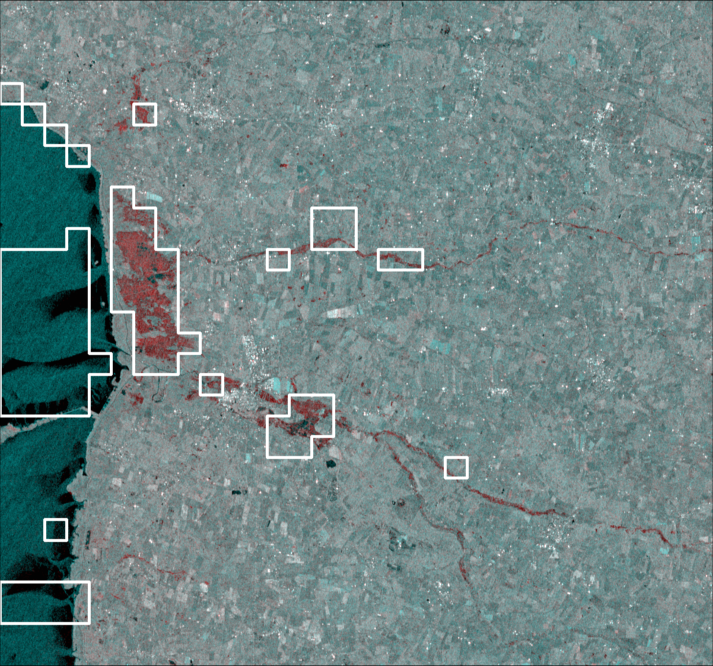

In [67]:
subset_edges = get_edges(bm_mask);
add_mask(imgVV,subset_edges,(1,1,1))

In [68]:
# fit bimodel
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed

# optimize y_RG and delta_sigma tresholds
t_0 = [y_seed+1, -1]
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0; autodiff = :forward)

# use optimize values to find flood mask
rg_thresholds = res.minimizer
rg_mask = (flood_band .<rg_thresholds[1]) .& (change_band.<rg_thresholds[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [69]:
# select the water pixelss in the selected tiles
data = reshape(flood_band,:)[reshape(rg_mask.&bm_mask,:)];
    
# Compare histogram with the emepircal in p_water
h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;

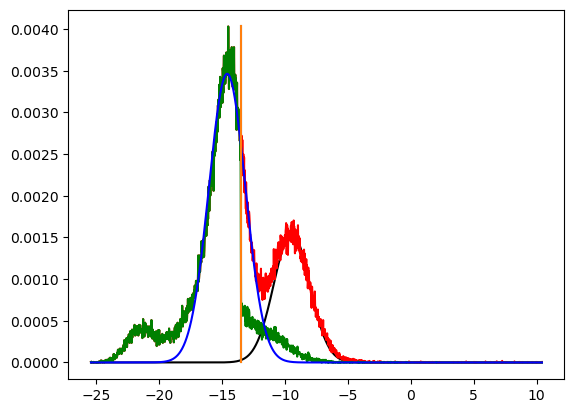

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14335aba8>

In [70]:

PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
#PyPlot.plot(y, bimodal_gauss_model(y, p_fit) )
PyPlot.plot(y,w_sel,color="g")
PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w),maximum(w),8))
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w),maximum(w),8))

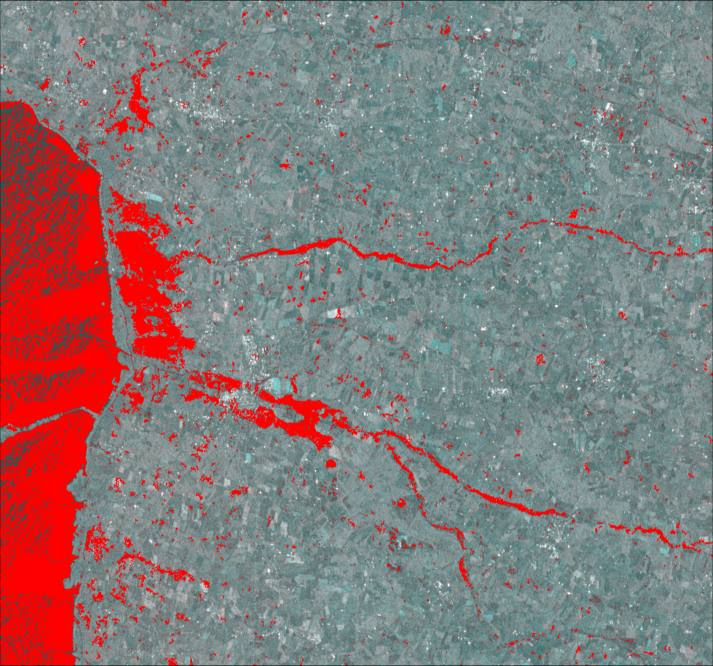

In [71]:
add_mask(imgVV,flood_mask,(1,0,0))

In [72]:
rg_thresholds

2-element Array{Float64,1}:
 11.241875           
  0.12812500000000046

In [73]:
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<rg_thresholds[1])
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);
    
# Remove flase positives and permant water.
final_mask = flood_mask .& (ref_mask .!=true);

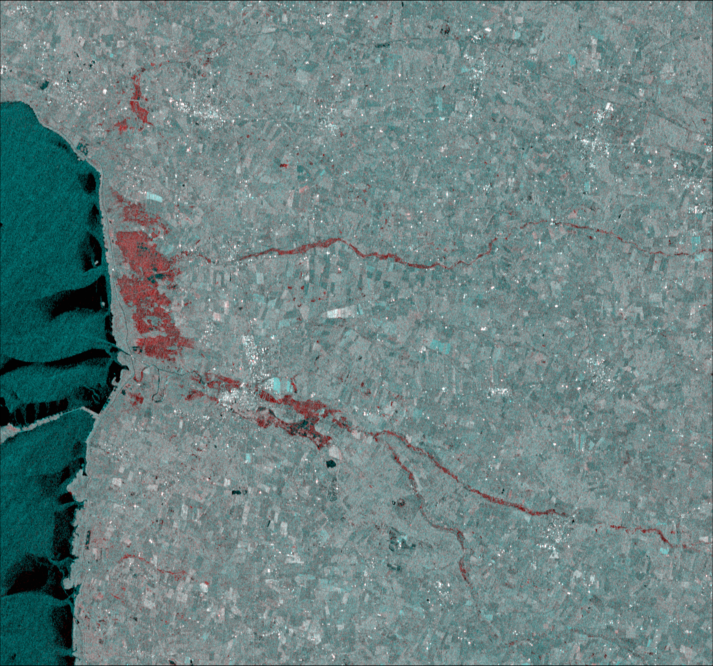

In [74]:
add_mask(imgVV,final_mask,(1,0,0))

## VH

In [47]:
co = VH[1][end:-1:1,:]
pre = VH[2][end:-1:1,:];

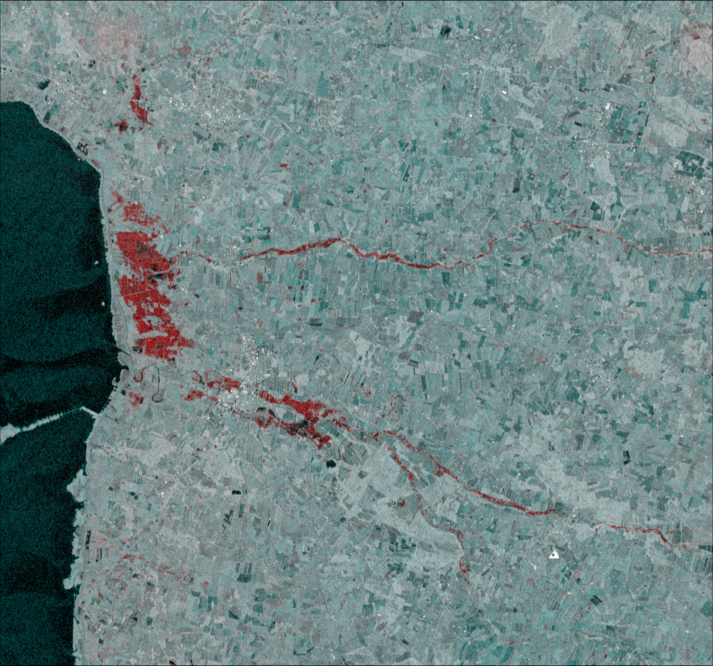

In [48]:
imgVH = pretty_img([co,pre],min_vh,max_vh)

In [49]:
flood_band = 10 .*log10.(co);
ref_band = 10 .*log10.(pre);
change_band = flood_band .- ref_band;

In [50]:
# Find the tiles to fit bimodal
bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;


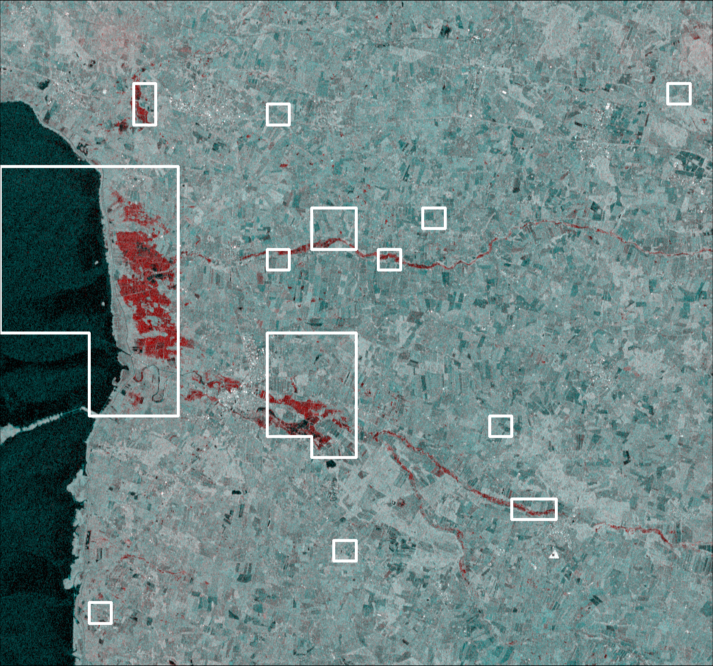

In [51]:
subset_edges = get_edges(bm_mask);
add_mask(imgVH,subset_edges,(1,1,1))

In [52]:
# fit bimodel
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed

# optimize y_RG and delta_sigma tresholds
t_0 = [y_seed+1, -1]
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0; autodiff = :forward)

# use optimize values to find flood mask
rg_thresholds = res.minimizer
rg_mask = (flood_band .<rg_thresholds[1]) .& (change_band.<rg_thresholds[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [53]:
# select the water pixelss in the selected tiles
data = reshape(flood_band,:)[reshape(rg_mask.&bm_mask,:)];
    
# Compare histogram with the emepircal in p_water
h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;

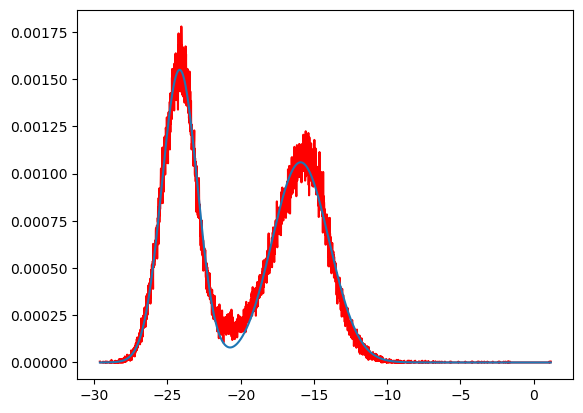

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1411ccd68>

In [54]:
PyPlot.figure()
PyPlot.plot(y,w,color="r")
PyPlot.plot(y, bimodal_gauss_model(y, p_fit) )


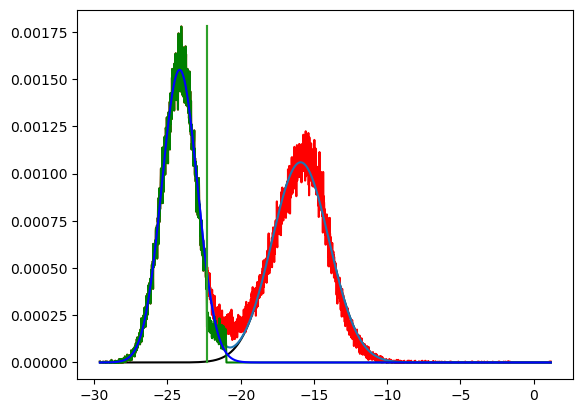

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x141cd1898>

In [55]:

PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(y, bimodal_gauss_model(y, p_fit) )
PyPlot.plot(y,w_sel,color="g")
PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w),maximum(w),8))
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w),maximum(w),8))

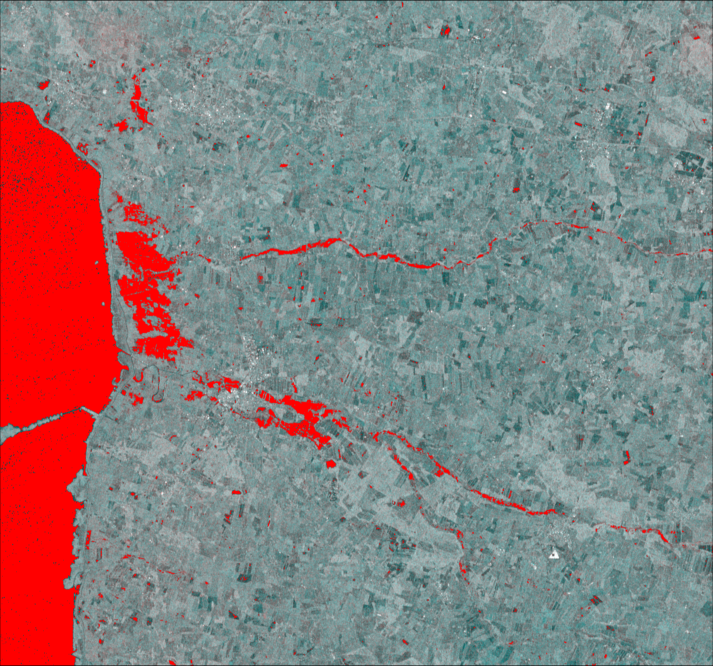

In [56]:
add_mask(imgVH,flood_mask,(1,0,0))

In [57]:
rg_thresholds

2-element Array{Float64,1}:
 -20.992578124999998 
  -0.8886718749999998

In [58]:
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<rg_thresholds[1])
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);
    
# Remove flase positives and permant water.
final_mask = flood_mask .& (ref_mask .!=true);

In [59]:
sum(reshape(final_mask,:))

30292

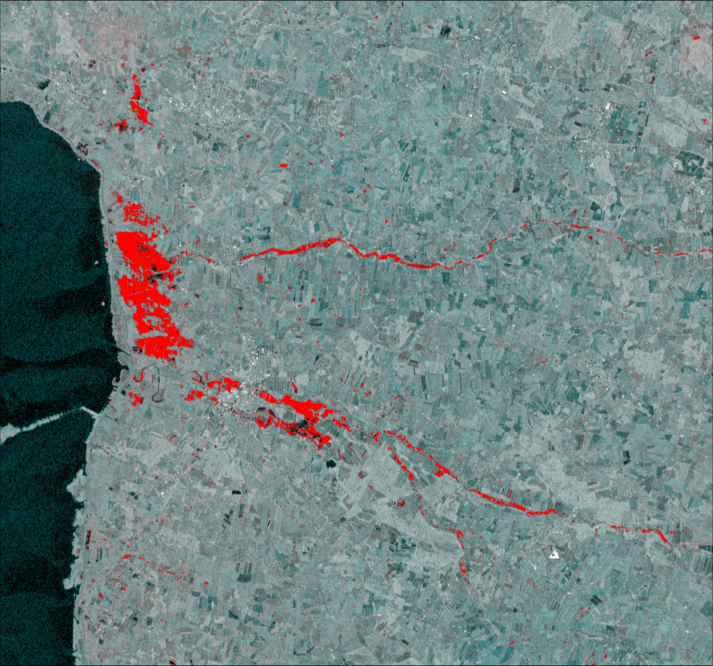

In [60]:
add_mask(imgVH,final_mask,(1,0,0))

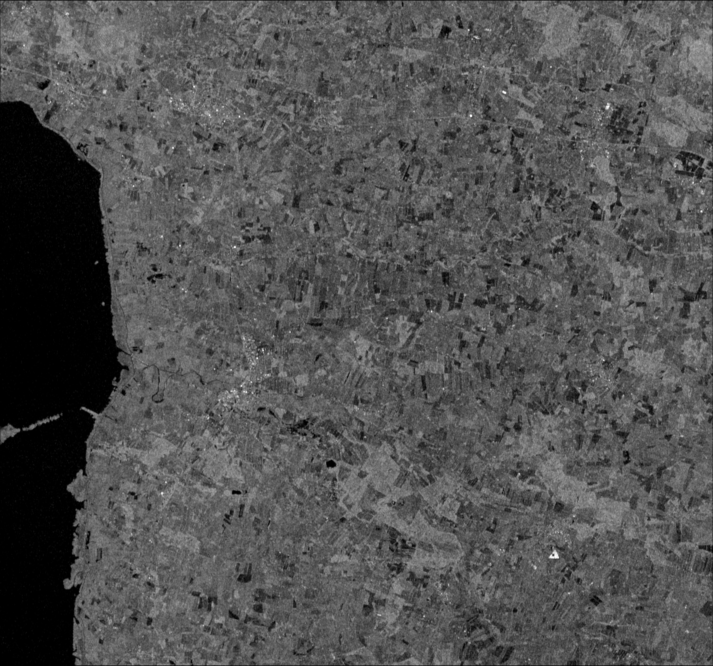

In [61]:
Colors.Gray.(db_scale_img(pre,min_vh,max_vh))